In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

# load clean data

At least at a first pass; redundant features removed, scaled, imputed missing values.

In [2]:
train = pd.read_csv('../../data/interim/train.csv')
train = pd.merge(train, pd.read_csv('../../data/interim/train_labels.csv'), on='id')
train.loc[:, 'date_recorded'] = pd.to_datetime(train.date_recorded)

In [3]:
train.sample(5)

id  longitude_imp  latitude_imp  amount_tsh date_recorded  \
18849  10711       0.416194      0.219392   -0.068769    2011-03-24   
16023  48237       0.496629      0.661533   -0.099150    2013-01-13   
55817  10253       0.754000      0.717396   -0.099150    2013-03-04   
54267  69484       0.869916      0.357763   -0.090035    2011-02-23   
44521   3032       0.192129      0.921311   -0.099150    2011-08-07   

               funder  gps_height          basin scheme_management  \
18849            Kkkt    0.722909     Lake Nyasa        Parastatal   
16023         unknown    0.593364       Internal               VWC   
55817  Isf/government    0.371338        Pangani   Water authority   
54267             Dwe    0.019767         Rufiji  Private operator   
44521              Un    0.022238  Lake Victoria               VWC   

      extraction_type_class        management  population  population_0  \
18849               gravity               vwc   -0.379567          True   
16023              handpump               vwc   -0.377444         False   
55817           submersible               vwc    0.342232         False   
54267              handpump  private operator   -0.377444         False   
44521           submersible               vwc   -0.379567          True   

       public_meeting         payment quality_group      quantity  \
18849            True     pay monthly          good        enough   
16023            True       never pay          good  insufficient   
55817            True       never pay          good  insufficient   
54267            True  pay per bucket          good        enough   
44521            True       never pay          good        enough   

             source     waterpoint_type status_group  
18849        spring  communal standpipe   functional  
16023  shallow well           hand pump   functional  
55817   machine dbh  communal standpipe   functional  
54267  shallow well           hand pump   functional  
44521        spring  communal standpipe   functional

In [4]:
# https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [5]:
def grouped_barplot(train, col, n=False, norm=True):
    
    index = train[col].unique()
    nonfunc = [train.loc[train.status_group == 'non functional', col].value_counts()[b] 
               if b in train.loc[train.status_group == 'non functional', col].value_counts() else 0 for b in index]
    func = [train.loc[train.status_group == 'functional', col].value_counts()[b] 
            if b in train.loc[train.status_group == 'functional', col].value_counts() else 0 for b in index]
    funcrep = [train.loc[train.status_group == 'functional needs repair', col].value_counts()[b] 
               if b in train.loc[train.status_group == 'functional needs repair', col].value_counts() else 0 for b in index]

    if norm:
        nonfunc = [a/sum(nonfunc) for a in nonfunc]
        func = [a/sum(func) for a in func]
        funcrep = [a/sum(funcrep) for a in funcrep]
    
    x = np.arange(len(index))  # the label locations
    width = 0.3  # the width of the bars

    fig, ax = plt.subplots(figsize=(8,4))
    rects1 = ax.bar(x - width, nonfunc, width, label='non functional')
    rects2 = ax.bar(x, func, width, label='functional')
    rects3 = ax.bar(x + width, funcrep, width, label='functional needs repair')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Count')
    ax.set_title(f'Status group per {col}')
    ax.set_xticks(x)
    ax.set_xticklabels(index)
    ax.legend()


    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 0),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    if n:
        autolabel(rects1)
        autolabel(rects2)
        autolabel(rects3)

    ax.legend(bbox_to_anchor=(1, 1))

    plt.xticks(rotation=60)

    return(ax)

# correlation matrices

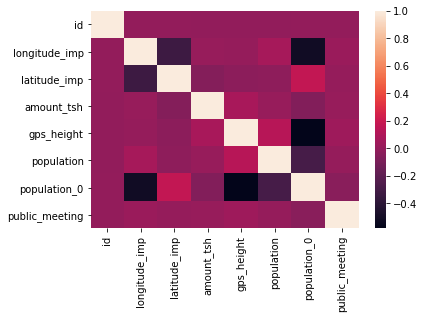

In [6]:
sns.heatmap(train.corr())
plt.show()

oh yeah, the categorical features. so I'll calculate the cramer v's by hand and mix them up!

In [7]:
"""
corr = pd.DataFrame(columns=train.columns[1:])

for c in train.columns[1:]:
    if (train[c].nunique() > 10) and train[c].dtype == object:
        continue
    elif (train[c].nunique() > 10) and train[c].dtype == float:
        corr.loc[c, :] = [ss.pearsonr(train[c], train[col])[0] if type(col) == float else 0 for col in train.columns[1:]]
    elif train[c].dtype == object:
        corr.loc[c, :] = [cramers_v(train[c], train[col]) for col in train.columns[1:]]
        
corr = corr[corr.columns].astype(float)
"""

'\ncorr = pd.DataFrame(columns=train.columns[1:])\n\nfor c in train.columns[1:]:\n    if (train[c].nunique() > 10) and train[c].dtype == object:\n        continue\n    elif (train[c].nunique() > 10) and train[c].dtype == float:\n        corr.loc[c, :] = [ss.pearsonr(train[c], train[col])[0] if type(col) == float else 0 for col in train.columns[1:]]\n    elif train[c].dtype == object:\n        corr.loc[c, :] = [cramers_v(train[c], train[col]) for col in train.columns[1:]]\n        \ncorr = corr[corr.columns].astype(float)\n'

In [8]:
# corr.to_csv('../data/interim/correlation_matrix.csv')
corr = pd.read_csv('../../data/interim/correlation_matrix.csv', index_col=0)
corr

longitude_imp  latitude_imp  amount_tsh  date_recorded  \
longitude_imp               0.000000      0.000000    0.000000       0.000000   
latitude_imp                0.000000      0.000000    0.000000       0.000000   
amount_tsh                  0.000000      0.000000    0.000000       0.000000   
gps_height                  0.000000      0.000000    0.000000       0.000000   
basin                       0.170074      0.170169    0.252233       0.508189   
extraction_type_class       0.129298      0.127990    0.230605       0.256062   
population                  0.000000      0.000000    0.000000       0.000000   
payment                     0.000000      0.000000    0.549792       0.318074   
quality_group               0.000000      0.000000    0.095808       0.212832   
quantity                    0.096631      0.096546    0.120951       0.217888   
source                      0.000000      0.000000    0.177197       0.294940   
waterpoint_type             0.140552      0.140577    0.143868       0.237302   
status_group                0.000000      0.000000    0.186075       0.190159   

                         funder  gps_height     basin  scheme_management  \
longitude_imp          0.000000    0.000000  0.000000           0.000000   
latitude_imp           0.000000    0.000000  0.000000           0.000000   
amount_tsh             0.000000    0.000000  0.000000           0.000000   
gps_height             0.000000    0.000000  0.000000           0.000000   
basin                  0.644536    0.366068  1.000000           0.243168   
extraction_type_class  0.521712    0.211509  0.250214           0.214528   
population             0.000000    0.000000  0.000000           0.000000   
payment                0.468497    0.219078  0.244785           0.208550   
quality_group          0.312240    0.069094  0.138687           0.129352   
quantity               0.331786    0.098936  0.138500           0.162008   
source                 0.490328    0.175575  0.244712           0.227685   
waterpoint_type        0.425152    0.108849  0.208322           0.188739   
status_group           0.295530    0.109545  0.126634           0.127591   

                       extraction_type_class  management  population  \
longitude_imp                       0.000000    0.000000    0.000000   
latitude_imp                        0.000000    0.000000    0.000000   
amount_tsh                          0.000000    0.000000    0.000000   
gps_height                          0.000000    0.000000    0.000000   
basin                               0.250214    0.221246    0.284539   
extraction_type_class               1.000000    0.199409    0.185646   
population                          0.000000    0.000000    0.000000   
payment                             0.231153    0.220509    0.169493   
quality_group                       0.159746    0.123600    0.095287   
quantity                            0.107632    0.187810    0.135493   
source                              0.454774    0.212254    0.168420   
waterpoint_type                     0.504297    0.153892    0.145901   
status_group                        0.241339    0.129565    0.141660   

                       public_meeting   payment  quality_group  quantity  \
longitude_imp                0.000000  0.000000       0.000000  0.000000   
latitude_imp                 0.000000  0.000000       0.000000  0.000000   
amount_tsh                   0.000000  0.000000       0.000000  0.000000   
gps_height                   0.000000  0.000000       0.000000  0.000000   
basin                        0.113219  0.244785       0.138687  0.138500   
extraction_type_class        0.089487  0.231153       0.159746  0.107632   
population                   0.000000  0.000000       0.000000  0.000000   
payment                      0.142064  1.000000       0.142927  0.127062   
quality_group                0.058738  0.142927       1.000000  0.279455   
quantity                     0.102284  0.127062       

In [9]:
corr = corr[corr.columns].astype(float)
sns.heatmap(corr)
plt.show()

OK so there is a lot of stuff here which is not particularly useful; interesting stuff:
- `waterpoint_type`, `quantity` and `extraction_type_class` have a relatively high correlation with the outcome
- `funder` and `extraction_type_class` correlate highly with other features
- `payment`, `amount_tsh`, `funder` correlate with each other

So maybe `funder` -- a feature that has nearly two thousand unique values -- should be discarded in favor of `payment`, which has only 7 unique values.

In [10]:
train.funder.nunique()

1898

In [11]:
train.payment.nunique()

7

# visualizations

## geographical features vs outcome

In [12]:
sns.scatterplot(data=train, x='latitude_imp', y='longitude_imp', hue='status_group')
plt.show()

In [13]:
_, ax = plt.subplots(3,3, figsize=(14,12), sharex=True, sharey=True)

for i, bas in enumerate(train.basin.unique()):
    l=False
    if i == 8: l="full"
        
    sns.scatterplot(data=train[train.basin == bas],
                    x='latitude_imp', y='longitude_imp', hue='status_group', 
                    legend=l, ax=ax[i//3][i%3])
    
    ax[i//3][i%3].set_title(bas)

plt.show()

looks like the lake which feeds the well is quite relevant for its current status (even more than just the coordinates!).

In [14]:
grouped_barplot(train, 'basin', True, False)
plt.show()

In [15]:
grouped_barplot(train, 'basin', False, True)
plt.show()

## well features vs outcome

In [16]:
sns.boxplot(data=train, x='status_group', y='gps_height')
plt.show()

does not look like this feature is particularly relevant to the outcome.

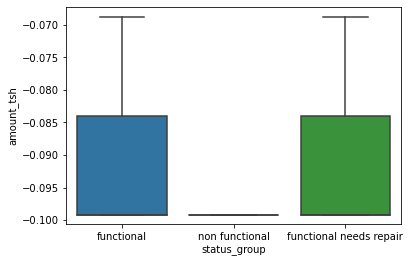

In [17]:
sns.boxplot(data=train, x='status_group', y='amount_tsh', showfliers=False)
plt.show()

the amount of water in the well is a very good indicator of functional vs. non-functional, but not so great at separating the wells that need repair from the rest.

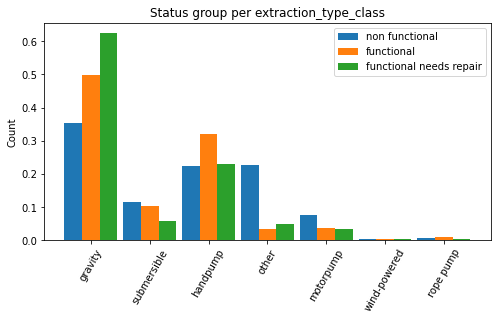

In [18]:
grouped_barplot(train, 'extraction_type_class', False, True)
plt.show()

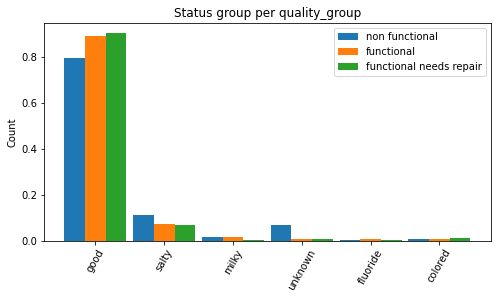

In [19]:
grouped_barplot(train, 'quality_group', False, True)
plt.show()

only apparently different one is "unknown" so this feature can probably be skipped, or reduced to a boolean "is_unknown"

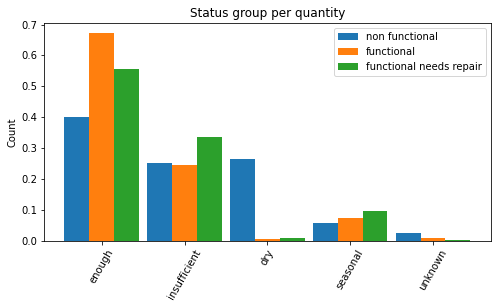

In [20]:
grouped_barplot(train, 'quantity', False, True)
plt.show()

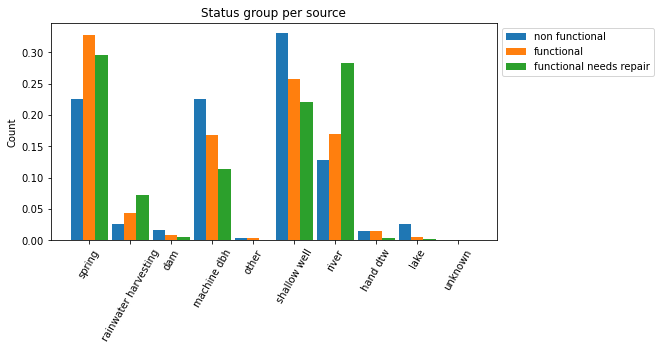

In [21]:
grouped_barplot(train, 'source', False, True)
plt.show()

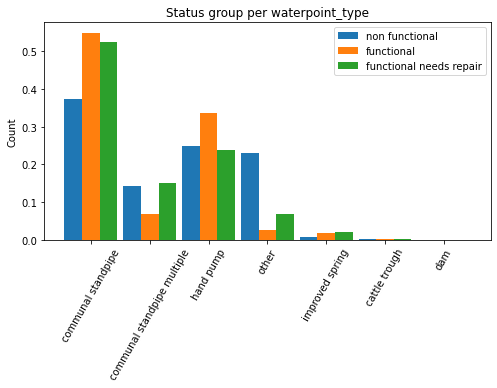

In [22]:
grouped_barplot(train, 'waterpoint_type', False, True)
plt.show()

the last three features seem very interesting

## well bureaucratic features

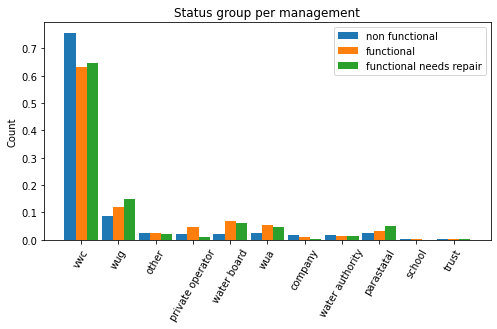

In [23]:
grouped_barplot(train, 'management', False, True)
plt.show()

the vast majority of the wells are under the same management. there the three outcomes are mostly equally represented. However this feature seems like a good indicator of the outcome in other cases.

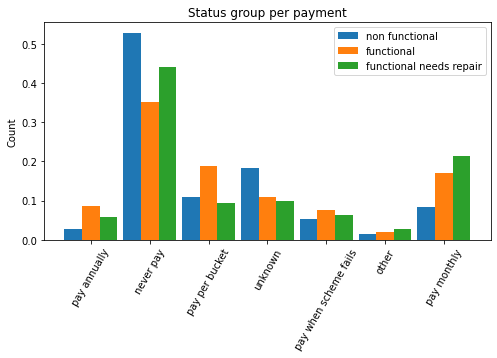

In [24]:
grouped_barplot(train, 'payment', False, True)
plt.show()

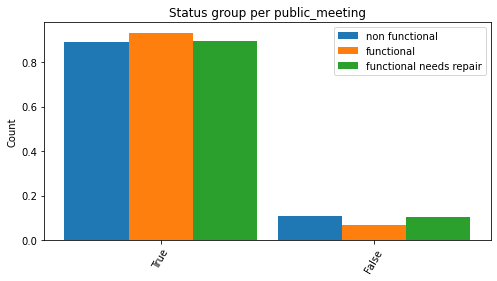

In [25]:
grouped_barplot(train, 'public_meeting', False, True)
plt.show()

the last one does not look very interesting

## data collection vs outcome

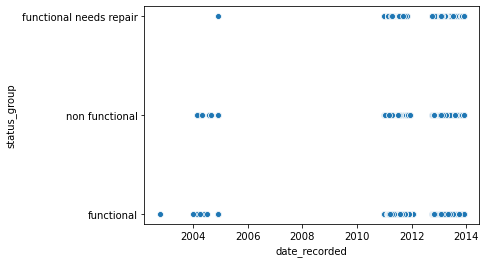

In [26]:
sns.scatterplot(data=train, x='date_recorded', y='status_group')
plt.show()

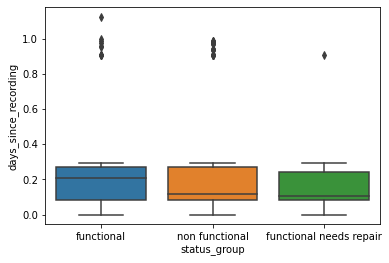

In [28]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split

train['days_since_recording'] = [a.days for a in (max(train.date_recorded) - train.date_recorded)]

y = train.pop('status_group')
X_train, _, _, _ = train_test_split(train, y, random_state=42)

scaler = MinMaxScaler()
scaler.fit(X_train.days_since_recording.values.reshape(-1, 1))

train['days_since_recording'] = scaler.transform(train.days_since_recording.values.reshape(-1, 1))
train['status_group'] = y

scaler_filename = "../../data/external/scaler_dayssince.save"
joblib.dump(scaler, scaler_filename)

sns.boxplot(data=train, x='status_group', y='days_since_recording')
plt.show()

## population

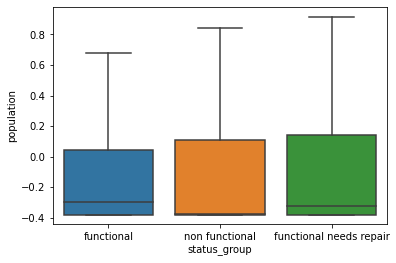

In [29]:
sns.boxplot(data=train, x='status_group', y='population', showfliers=False)
plt.show()

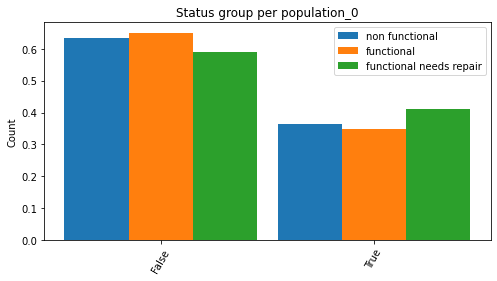

In [36]:
grouped_barplot(train, 'population_0', False, True)
plt.show()

The second by itself does not seem to hold a lot of information; perhaps the combination is better!